In [2]:
# Cart_pole program with gym
# pip install gym torch numpy
from pre_req import *
import matplotlib.pyplot as plt
from IPython.display import clear_output


Training on device: cuda


In [19]:

csv_filename= "vanilla_lunar.csv"

def optimize_model(memory, policy_net, target_net, optimizer, batch_size=64, gamma=0.99):
    if len(memory) < batch_size:
        return
    transitions = random.sample(memory, batch_size)
    batch = list(zip(*transitions))

    # Unpack and convert lists directly to tensors
    states = torch.tensor(batch[0], dtype=torch.float32, device=device)
    actions = torch.tensor(batch[1], dtype=torch.long, device=device)
    rewards = torch.tensor(batch[2], dtype=torch.float32, device=device)
    next_states = torch.tensor(batch[3], dtype=torch.float32, device=device)
    dones = torch.tensor(batch[4], dtype=torch.float32, device=device)

    # Ensure all actions are column vectors
    actions = actions.unsqueeze(-1)

    # Neural network operations
    state_action_values = policy_net(states).gather(1, actions).squeeze(-1)
    next_state_values = target_net(next_states).max(1)[0]
    next_state_values *= (1 - dones)  # Zero out values for done states
    expected_state_action_values = (next_state_values * gamma) + rewards

    # Loss calculation and backpropagation
    loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()


In [17]:

optimizer = optim.Adam(policy_net.parameters())
memory = deque(maxlen=10000)
epochs = 1000
sync_freq = 10
batch_size = 64
 
# Modify your training loop to include plotting
for epoch in range(epochs):
    state, _ = env.reset()
    total_reward = 0
    total_loss = 0  # Initialize total loss for the episode
    count_steps = 0  # Count the number of optimization steps

    epsilon = get_epsilon(epoch)
    while True:
        action = choose_action(state, policy_net, epsilon)
        next_state, reward, done, truncated, info = env.step(action)
        memory.append((list(state), action, reward, list(next_state), int(done or truncated)))
        state = next_state
        total_reward += reward
        loss= optimize_model(memory, policy_net, target_net, optimizer, batch_size)

        if loss!=None:
            total_loss += loss
            count_steps += 1
        if done or truncated:
            break
 
    if epoch % sync_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

    torch.save(policy_net.state_dict(), f'models/vanilla_lunarlander_final.pth')
    if epoch %100 ==0:
        torch.save(policy_net.state_dict(), f'models/vanilla_lunar_{epoch}.pth')

    average_loss = total_loss / count_steps if count_steps != 0 else 0
  
    print(f"Epoch {epoch}, Total reward: {total_reward}, Epsilon: {epsilon}, average loss: {average_loss}")
    save_to_csv([epoch, total_reward, epsilon, average_loss], csv_filename)
    clear_output(wait=True)  # Clear the output to make the new plot visible
 
env.close()


# After training, visualize the policy
num_episodes = 5
env_test = gym.make(environment, render_mode="human")
for i in range(num_episodes):
    state, _ = env_test.reset()
    done = False
    truncated = False  # Also handle truncation in visualization
    total_reward = 0
    while not done and not truncated:
        # env.render()
        action = choose_action(state, policy_net, epsilon=0)  # Use the trained policy without exploration
        next_state, reward, done, truncated, info = env_test.step(action)
        state = next_state
        total_reward += reward
    print(f"Test Episode {i + 1}: Total Reward = {total_reward}")

env_test.close()

c:\Users\jana2\anaconda3\envs\gym\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Test Episode 1: Total Reward = -14.008070618913365
Test Episode 2: Total Reward = -2.3571817974856515
Test Episode 3: Total Reward = 249.44990961334528
Test Episode 4: Total Reward = 52.53256579874596
Test Episode 5: Total Reward = 66.60264031949288


## Q-Value for Set of Actions

Test Episode 5: Total Reward = 54.84339860197167


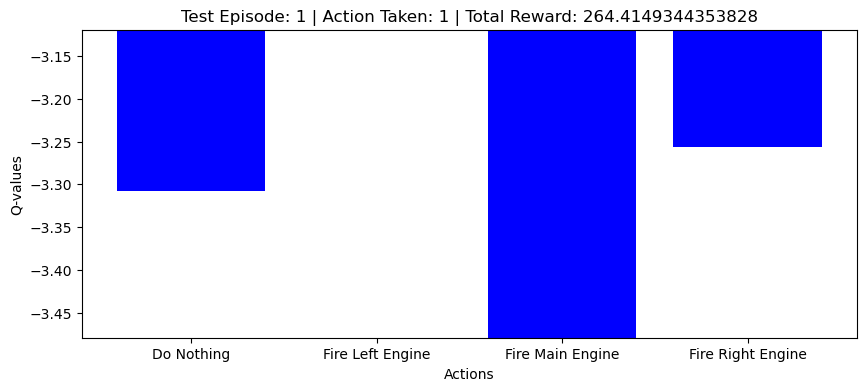

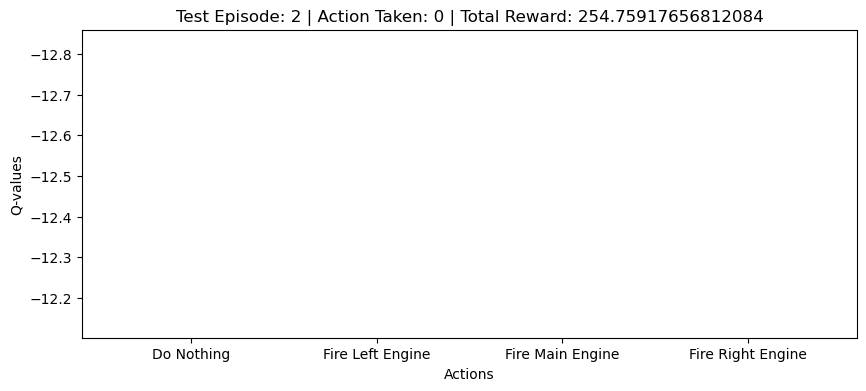

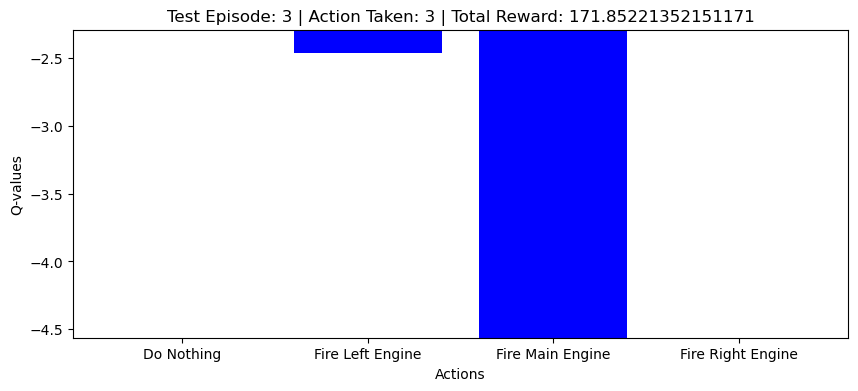

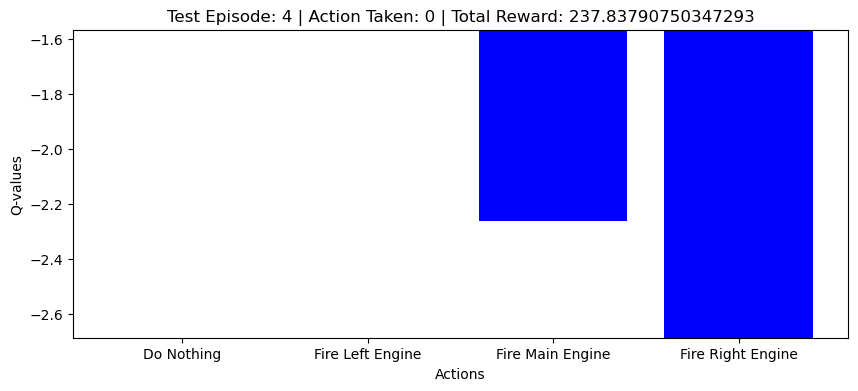

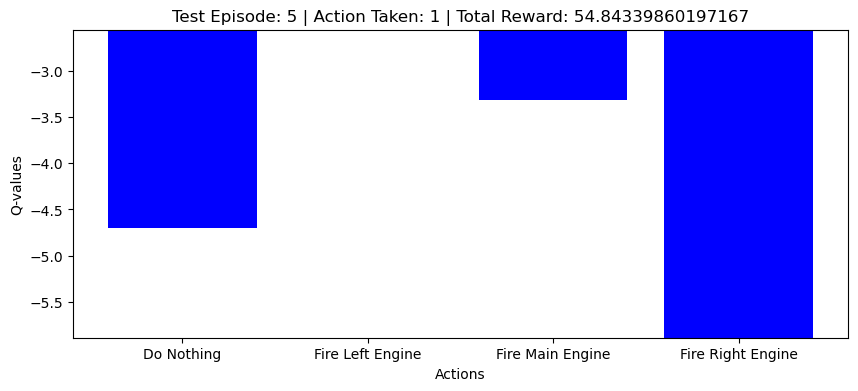

In [6]:
import torch
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import gym

model_path='models/vanilla_lunarlander_final.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net.to(device)
policy_net.load_state_dict(torch.load(model_path))
policy_net.eval()

env_test = gym.make(environment)
num_episodes = 5

action_names = ['Do Nothing', 'Fire Left Engine', 'Fire Main Engine', 'Fire Right Engine']  # Example for Lunar Lander
env_test = gym.make(environment, render_mode="human")
num_episodes = 5

for i in range(num_episodes):
    state, _ = env_test.reset()
    done = False
    truncated = False
    total_reward = 0
    plt.figure(figsize=(10, 4))

    while not done and not truncated:
        # Calculate Q-values and choose action
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)  # Ensure data is on the same device as the model
        with torch.no_grad():
            q_values = policy_net(state_tensor)
        q_values_np = q_values.cpu().numpy().flatten()  # Move data back to CPU for plotting
        action = torch.argmax(q_values).item()

        # Perform action in the environment
        next_state, reward, done, truncated, info = env_test.step(action)
        total_reward += reward
        state = next_state

        # Plotting Q-values
        plt.clf()
        actions = list(range(len(q_values_np)))
        colors = ['blue' if x != action else 'red' for x in actions]  # Highlight the selected action in red
        plt.bar(action_names, q_values_np, color=colors)
        plt.title(f'Test Episode: {i + 1} | Action Taken: {action} | Total Reward: {total_reward}')
        plt.xlabel('Actions')
        plt.ylabel('Q-values')
        #plt.xticks(rotation=45)
        plt.ylim([min(0, min(q_values_np)), max(q_values_np) + 0.1 * max(q_values_np)])
        display(plt.gcf())
        clear_output(wait=True)

    print(f"Test Episode {i + 1}: Total Reward = {total_reward}")

env_test.close()


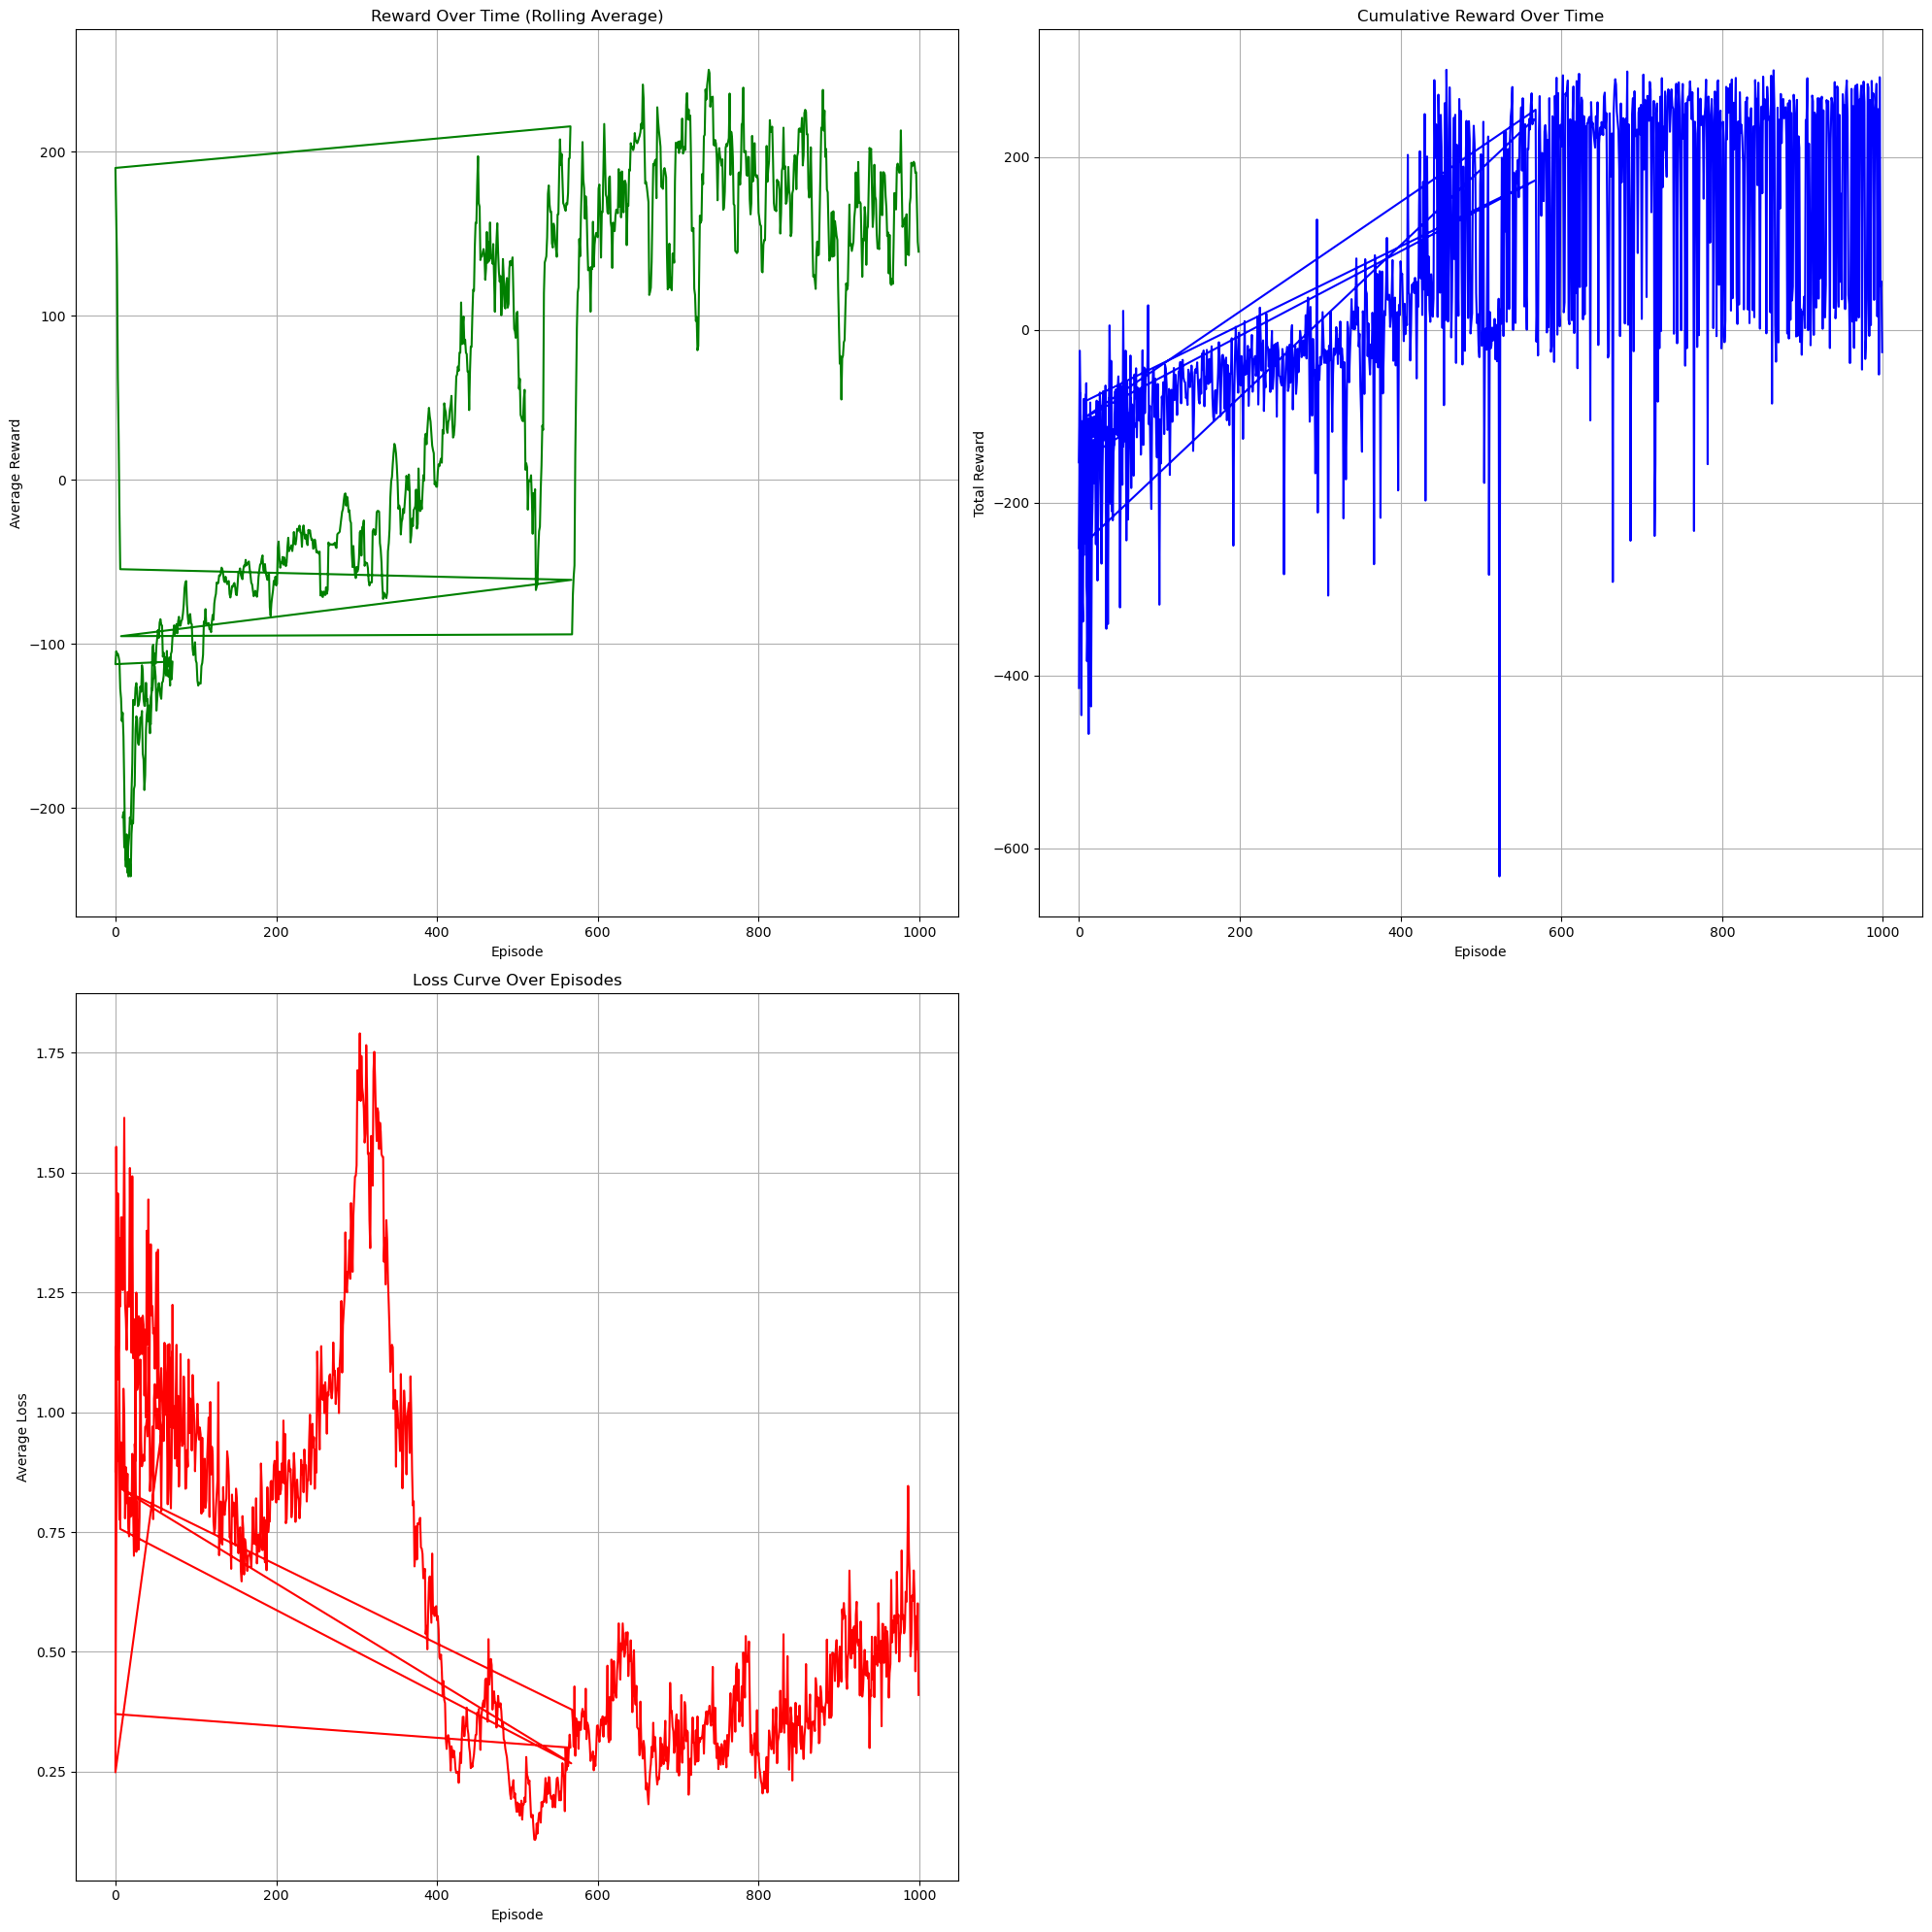

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV
df = pd.read_csv('vanilla_lunar.csv', header=None)
df.columns = ['Episode', 'Total Reward', 'Epsilon', 'Avg Loss']

# Calculate the rolling average of the reward
rolling_window = 10  # You can adjust the window size as needed
df['Rolling Avg Reward'] = df['Total Reward'].rolling(window=rolling_window).mean()

# Plotting Cumulative Reward over Time
plt.figure(figsize=(20, 20))

# Plotting Reward Over Time with Rolling Average
plt.subplot(2, 2, 1)
plt.plot(df['Episode'], df['Rolling Avg Reward'], color='green')
plt.title('Reward Over Time (Rolling Average)')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.grid(True)

# Plotting Cumulative Reward Over Time
plt.subplot(2, 2, 2)
plt.plot(df['Episode'], df['Total Reward'], linestyle='-', color='blue')
plt.title('Cumulative Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

# Plotting Loss Curve
plt.subplot(2, 2, 3)
plt.plot(df['Episode'], df['Avg Loss'], linestyle='-', color='red')
plt.title('Loss Curve Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Loss')
plt.grid(True)


plt.tight_layout()
plt.show()
